In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import KNeighborsClassifier
import math

In [2]:
df_ring = pd.read_csv('dataSetRingsWithSpeckle.csv', names=['class', 'feature1', 'feature2'])

In [3]:
def trainKNN(df, k):
    X = df[['feature1','feature2']]
    y = df['class']
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    return clf, df, k

In [4]:
def plotKNNStatisticSurface(clf, df, k):
    f1_min, f1_max = df['feature1'].min() - 0.2, df['feature1'].max() + 0.2
    f2_min, f2_max = df['feature2'].min() - 0.2, df['feature2'].max() + 0.2
    ff1, ff2 = np.meshgrid(np.arange(f1_min, f1_max, 0.1), np.arange(f2_min, f2_max, 0.1))
    X_test = np.c_[ff1.ravel(), ff2.ravel()]
    Z = clf.predict_proba(X_test)
    Z = Z[:,1]
    Z = Z.reshape(ff1.shape)
    Z_contour = clf.predict(X_test)
    Z_contour = Z_contour.reshape(ff1.shape)
    plt.figure(dpi=150)
    colors = ['azure', 'royalblue']
    cm = LinearSegmentedColormap.from_list('my', colors, N=k+1)
    plt.contour(ff1, ff2, Z_contour, colors='gold', linewidths=1)
    plt.pcolormesh(ff1, ff2, Z, cmap=cm)
    plt.colorbar()
    plt.scatter(df[df['class']==0]['feature1'],df[df['class']==0]['feature2'],c='b',s=5,label='$H_0$')
    plt.scatter(df[df['class']==1]['feature1'],df[df['class']==1]['feature2'],c='orangered',s=5,label='$H_1$')
    plt.legend()
    plt.xlim(f1_min, f1_max)
    plt.ylim(f2_min, f2_max)
    plt.title("2-Class KNN (k = %i)"% k)
    plt.show()
    return Z_contour

In [5]:
def runDANN(train, test, k, epsilon):
    #data0 = train[train['class']==0][['feature1','feature2']]
    #data1 = train[train['class']==1][['feature1','feature2']]
    #N0 = len(data0)
    #N1 = len(data1)
    #N = N0 + N1
    #l2_norm = lambda a, b: math.sqrt((a[0]-b[0]) ** 2 + (a[1]-b[1]) ** 2)
    data_tr = train[['feature1', 'feature2']].values
    difference_matr = data_tr - test
    distance = np.sqrt(np.square(difference_matr[:, 0]) + np.square(difference_matr[:, 1]))
    #distance = np.array([l2_norm(test,x) for i,x in train[['feature1','feature2']].iterrows()])
    df_copy = train.copy()
    df_copy['distance'] = distance
    df_sorted = df_copy.sort_values(by='distance')
    neighbors = df_sorted.iloc[0:100]
    neighbors0 = neighbors[neighbors['class']==0][['feature1','feature2']].values
    neighbors1 = neighbors[neighbors['class']==1][['feature1','feature2']].values
    N0 = neighbors0.shape[0]
    N1 = neighbors1.shape[0]
    N = N0 + N1
    if N0 == 0:
        mu1 = np.mean(neighbors1,axis=0)
        data = neighbors1 - mu1
    elif N1 == 0:
        mu0 = np.mean(neighbors0,axis=0)
        data = neighbors0 - mu0
    else:
        mu0 = np.mean(neighbors0,axis=0)
        mu1 = np.mean(neighbors1,axis=0)
        data = np.concatenate(((neighbors0 - mu0),(neighbors1 - mu1)),axis=0)
    W = np.cov(data.T)
    x_mu = np.mean(neighbors[['feature1','feature2']].values, axis=0)
    if N0 == 0:
        mu1_xmu = mu1 - x_mu
        B = (N1/N)*np.dot(mu1_xmu[:,np.newaxis],mu1_xmu[np.newaxis,:])
    elif N1 == 0:
        mu0_xmu = mu0 - x_mu
        B = (N0/N)*np.dot(mu0_xmu[:,np.newaxis],mu0_xmu[np.newaxis,:])
    else:
        mu0_xmu = mu0 - x_mu
        mu1_xmu = mu1 - x_mu
        B = (N0/N)*np.dot(mu0_xmu[:,np.newaxis],mu0_xmu[np.newaxis,:])+(N1/N)*np.dot(mu1_xmu[:,np.newaxis],mu1_xmu[np.newaxis,:])
    Sigma = np.dot(np.dot(np.linalg.inv(W),B),np.linalg.inv(W)) + epsilon * np.linalg.inv(W)
    metric = lambda a, b: np.dot(np.dot((a-b),Sigma), (a-b))
    #deformed_distance = np.array([metric(x.values,test) for i,x in train[['feature1','feature2']].iterrows()])
    deformed_distance = np.sum(np.dot(difference_matr, Sigma) * difference_matr, axis = 1)
    df_deformed = train.copy()
    df_deformed['deformed_distance'] = deformed_distance
    dneighbors = df_deformed.sort_values(by='deformed_distance').iloc[0:k]
    n0 = len(dneighbors[dneighbors['class']==0])
    n1 = len(dneighbors[dneighbors['class']==1])
    proba = n1 / k
    if proba >= 0.5:
        predict = 1
    else:
        predict = 0
    return proba, predict

In [6]:
def plotDANNStatistic(df, k, epsilon):
    f1_min, f1_max = df['feature1'].min() - 0.2, df['feature1'].max() + 0.2
    f2_min, f2_max = df['feature2'].min() - 0.2, df['feature2'].max() + 0.2
    ff1, ff2 = np.meshgrid(np.arange(f1_min, f1_max, 0.1), np.arange(f2_min, f2_max, 0.1))
    X_test = np.c_[ff1.ravel(), ff2.ravel()]
    Z = np.array([runDANN(df,test,k, epsilon) for test in tqdm(X_test,total=X_test.shape[0],leave=False)])
    Z_contour = Z[:,1]
    Z = Z[:,0]
    Z = Z.reshape(ff1.shape)
    Z_contour = Z_contour.reshape(ff1.shape)
    plt.figure(dpi=150)
    colors = ['azure', 'royalblue']
    cm = LinearSegmentedColormap.from_list('my', colors, N=k+1)
    plt.contour(ff1, ff2, Z_contour, colors='gold', linewidths=1)
    plt.pcolormesh(ff1, ff2, Z, cmap=cm)
    plt.colorbar()
    plt.scatter(df[df['class']==0]['feature1'],df[df['class']==0]['feature2'],c='b',s=5,label='$H_0$')
    plt.scatter(df[df['class']==1]['feature1'],df[df['class']==1]['feature2'],c='orangered',s=5,label='$H_1$')
    plt.legend()
    plt.xlim(f1_min, f1_max)
    plt.ylim(f2_min, f2_max)
    plt.title("2-Class DANN (k = %i)"% k)
    plt.show()
    return Z_contour

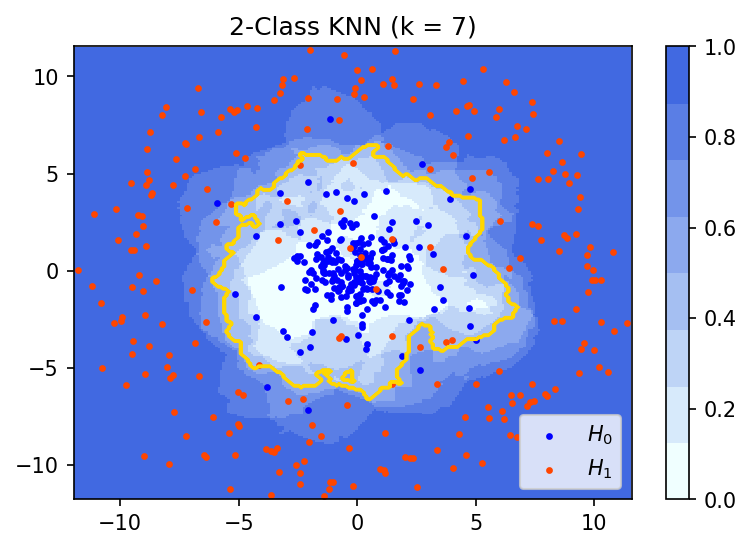

In [7]:
clf, df, k = trainKNN(df_ring, 7)
Z_knn = plotKNNStatisticSurface(clf, df, k)

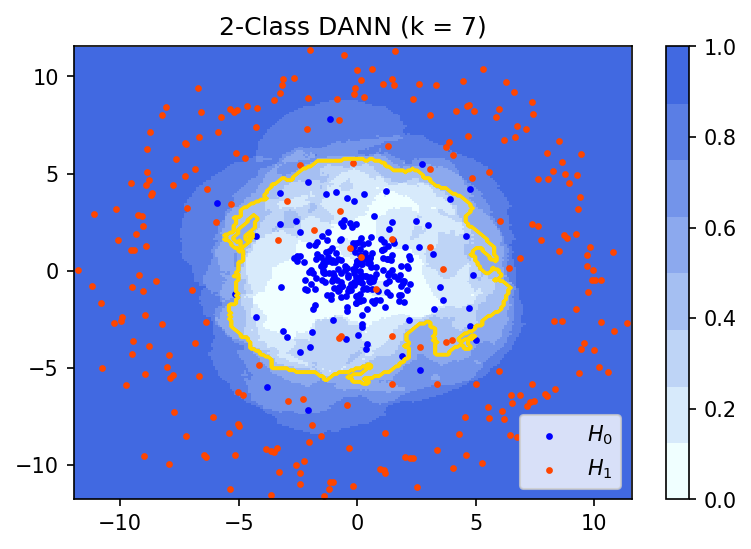

In [8]:
Z_dann = plotDANNStatistic(df_ring, 7, 1)

In [9]:
def plotBoundaries(df, Z_knn, Z_dann):
    f1_min, f1_max = df['feature1'].min() - 0.2, df['feature1'].max() + 0.2
    f2_min, f2_max = df['feature2'].min() - 0.2, df['feature2'].max() + 0.2
    ff1, ff2 = np.meshgrid(np.arange(f1_min, f1_max, 0.1), np.arange(f2_min, f2_max, 0.1))
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    cntr1 = ax.contour(ff1, ff2, Z_knn, linewidths=1, colors='gold')
    cntr2 = ax.contour(ff1, ff2, Z_dann, linewidths=1, colors='m')
    h1,_ = cntr1.legend_elements()
    h2,_ = cntr2.legend_elements()
    plt.scatter(df[df['class']==0]['feature1'],df[df['class']==0]['feature2'],c='b',s=5,label='$H_0$')
    plt.scatter(df[df['class']==1]['feature1'],df[df['class']==1]['feature2'],c='orangered',s=5,label='$H_1$')
    ax.legend([h1[0], h2[0]], ['KNN', 'DANN'])
    plt.xlim(f1_min, f1_max)
    plt.ylim(f2_min, f2_max)
    plt.title("Decision Boundaries")
    plt.show()

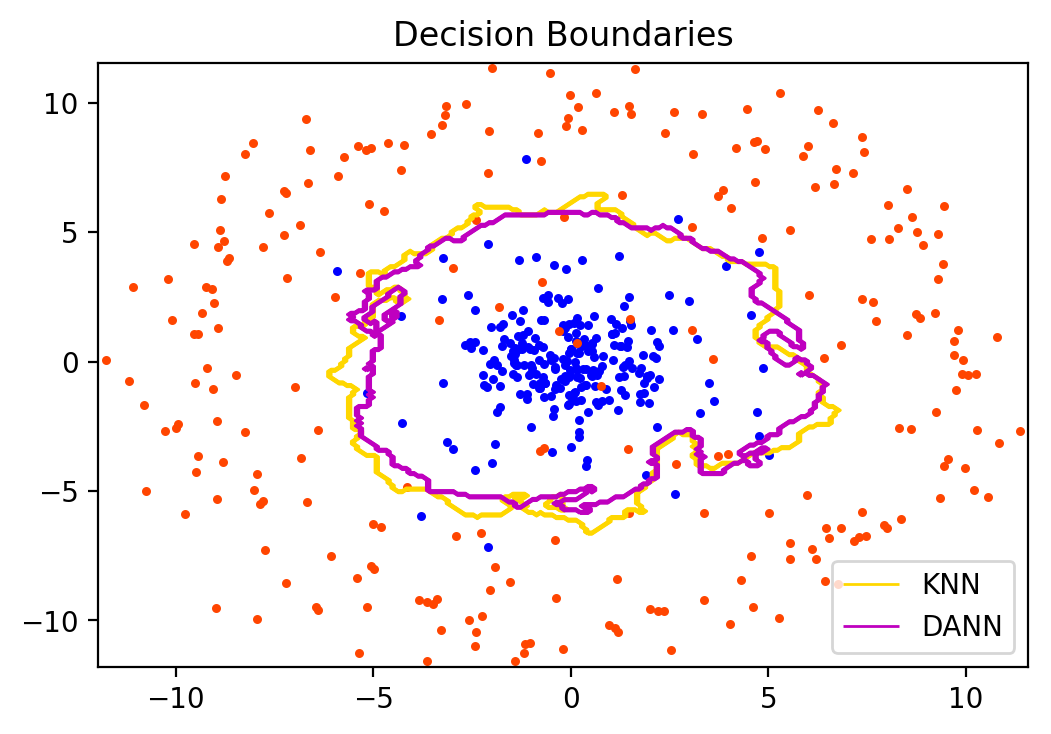

In [10]:
plotBoundaries(df_ring, Z_knn, Z_dann)